## Identificando Agregação Espaço-Temporal
Werneck, Guilherme L., e Claudio J. Struchiner. “Estudos de agregados de doença no espaço-tempo: conceitos, técnicas e desafios”. Cadernos de Saúde Pública 13, nº 4 (outubro de 1997): 611–24. https://doi.org/10.1590/S0102-311X1997000400005.

> "Agregação espaço-temporal pode ser entendida como uma forma de não-aleatoriedade na distribuição da doença : em que, entre eventos próximos no tempo, existe um excesso não esperado de eventos que estão também próximos no espaço (McAullife & Afifi, 1984). Este conceito é distinto do de agregação espacial e temporal, e também tem sido denominado interação espaço-temporal (Knox, 1991; Jacquez et al., 1996). De fato, agregação espaço-temporal pode ocorrer na ausência de agregação espacial e temporal, ou mesmo estar ausente quando existe agregação nas duas dimensões (Estève et al., 1994)."

Seguindo o exemplo da publicação são criadas algumas visualizações a seguir para identificar agregação espaço-temporal.

São necessárias formas geométricas adquiridas no site do IBGE (apenas .shp, .shx e .dbf):

- https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/Brasil/BR/BR_Municipios_2020.zip
- Descompactar em `data/raw/poligonos`


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(ratio, shapes):
    '''
    | ratio: arquivo .csv com taxa de incidência ou outra medida anual para cada município identificado 
    | por código de 6 dígitos.
    |
    | shapes: arquivo de polígonos do IBGE para cada município identificado por código de 7 dígitos 
    | (necessário desconsiderar o último).
    | 
    | returns: dataframe `ratio` acrescido da média do último triênio (trienio) e a média de todos anos para cada
    | município; polígono de cada município (geometry).
    '''
    df = pd.read_csv(ratio).set_index('CO_MN_INF') 
   
    # *.shp vai utilizar o arquiv .shx e .dbf 
    shapes = gpd.read_file(shapes)
    shapes.CD_MUN = shapes.CD_MUN.apply(lambda x: x[0:6])
    shapes.CD_MUN = shapes.CD_MUN.astype(int)
    shapes = shapes.set_index('CD_MUN')
    
    anos = df.columns
    df['trienio'] = df.loc[:, anos[-3:]].mean(axis=1)    
    df['media'] = df.loc[:, anos].mean(axis=1)
    df['geometry'] = df.index.map(shapes['geometry'].to_dict())
    return df

def spatial_agregation(data, column='media'):
    temp_df = data.loc[:, [column, 'geometry']]
    if column == 'media':
        title = '2007 a 2019'
    elif column == 'trienio':
        title = '2017 a 2019'        
    elif column in data.columns[0:-3]:
        title = column        
        
    #para = para.loc[para.acumulado > data.mean(axis=1).mean(), :]
    #para['acumulado'] = (para.acumulado - para.acumulado.min()) / (para.acumulado.max() - para.acumulado.min())

    gdf = gpd.GeoDataFrame(temp_df.replace(0, np.nan), geometry='geometry', crs="EPSG:4326")
    fig, ax = plt.subplots(figsize=(15,9))
    plt.rcParams['font.size'] = 12
    gdf.plot(
        column=column, 
        ax=ax,
        cmap = plt.cm.Oranges,            
        scheme='equalinterval',
        k=8,
        legend = True,
        missing_kwds={
            'color': 'white',
            'edgecolor': 'gray',
            'hatch': '///',
            'label': 'Sem casos registrados'
        }
    )
    ax.set_title(
        f'''Agregação espacial
        Média do período {title}
        ''', 
        fontdict = {'fontsize':22, 'color':'darkblue'}
    )
    ax.set_axis_off()
    #move legend to an empty space
    ax.get_legend().set_bbox_to_anchor((1.25,.40))
    fig.savefig(f'../images/spatial-{title}.png', dpi=fig.dpi)
    plt.show()
    display(mapclassify.classifiers.EqualInterval(gdf[column], k=8))

def temporal_agregation(data):
    temp_df = data.loc[:, anos].mean(axis=0)

    #se aumentou mais que 50% em relação a media de todos anos (critério aleatório)
    clrs = ['indianred' if (temp_df.iloc[i] / temp_df.iloc[:i].mean()) > 1.5 else 'cornflowerblue' for i in range(1, temp_df.size)]  
    clrs.insert(0, 'cornflowerblue')
    fig, ax = plt.subplots(figsize=(15,9))
    plt.rcParams['font.size'] = 12
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    temp_df.plot(
        kind='bar',
        ax=ax,
        color=clrs
    )
    temp_df.plot(
        kind='line',
        ax=ax
    )
    plt.xticks(rotation=45, ha='right')
    ax.set_title(
        '''Incidência média por ano (casos por 100.000 hab.)
        Agregação temporal de casos\n''', 
        fontdict = {'fontsize':22, 'color':'darkblue'}
    )
    fig.savefig('../images/temporal.png', dpi=fig.dpi)
    plt.show()
    
def spatial_temporal_agregation(data, region='mesorregiao'):
    group = data.groupby('mesorregiao')[anos].mean()
    group['mean'] = group.mean(axis=1)
    group = group.sort_values(ascending=False,by='mean')
    group = group.drop('mean',axis=1)
    #display(group)
    fig, ax = plt.subplots(1, figsize=(16, 10))
    plt.rcParams['font.size'] = 12
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    ax.set_title(
        '''Incidência média por ano de cada mesorregião
        Agregação temporal e espacial de casos\n''', 
        fontdict = {'fontsize':22,'color':'darkblue'}
    )
    #move legend to an empty space
    group.T.plot(kind='bar', stacked=True, ax=ax, alpha=0.8)
    plt.xticks(rotation=45, ha='right')
    ax.get_legend().set_bbox_to_anchor((0.6,0.7))
    fig.savefig('../images/spatio-temporal.png', dpi=fig.dpi)    
    plt.show()  

In [3]:
#dados de municípios
mun = pd.read_csv('../data/processed/processed_municipios.csv') 

#dataframe com polígonos
ratio = '../data/indicadores/visceral/indicador_15_taxa_incidencia_municipio_infeccao.csv'
shapes = '../data/raw/poligonos/BR_Municipios_2020.shp'
df = load_data(ratio, shapes)

#dataframe somente Pará
idx_para = mun.loc[(mun.estado == 'Pará'), ['ibge_code', 'mesorregiao']].set_index('ibge_code')['mesorregiao'].to_dict()
para = df.loc[idx_para.keys(), :]
#adiciona a mesorregião de cada município
para['mesorregiao'] = para.index.map(idx_para)

#anos
anos = para.columns[0:13]

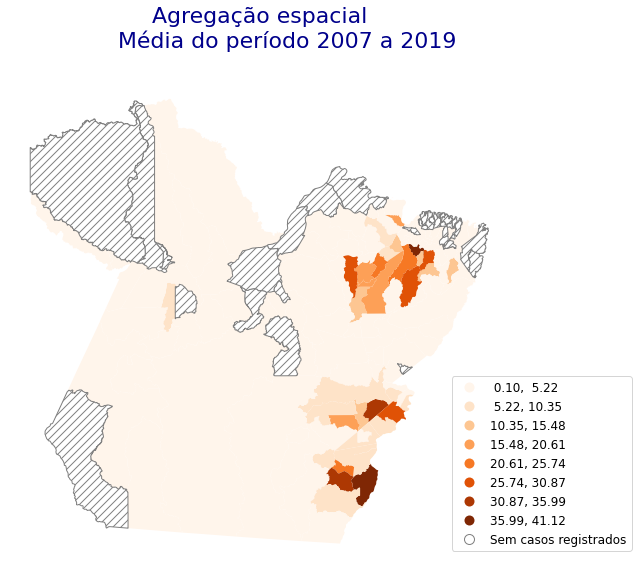

EqualInterval         

   Interval      Count
----------------------
[  nan,  5.22] |   109
( 5.22, 10.35] |    13
(10.35, 15.48] |     6
(15.48, 20.61] |     5
(20.61, 25.74] |     3
(25.74, 30.87] |     4
(30.87, 35.99] |     2
(35.99, 41.12] |     2

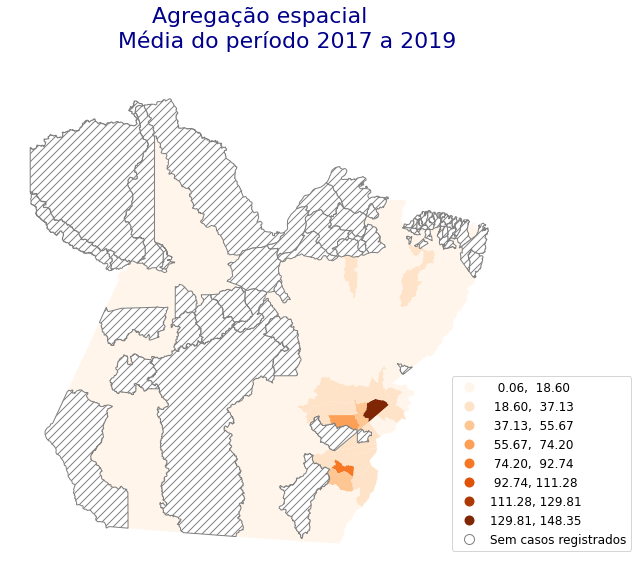

EqualInterval           

    Interval       Count
------------------------
[   nan,  18.60] |   126
( 18.60,  37.13] |    13
( 37.13,  55.67] |     2
( 55.67,  74.20] |     1
( 74.20,  92.74] |     1
( 92.74, 111.28] |     0
(111.28, 129.81] |     0
(129.81, 148.35] |     1

In [4]:
spatial_agregation(para)
spatial_agregation(para, 'trienio')

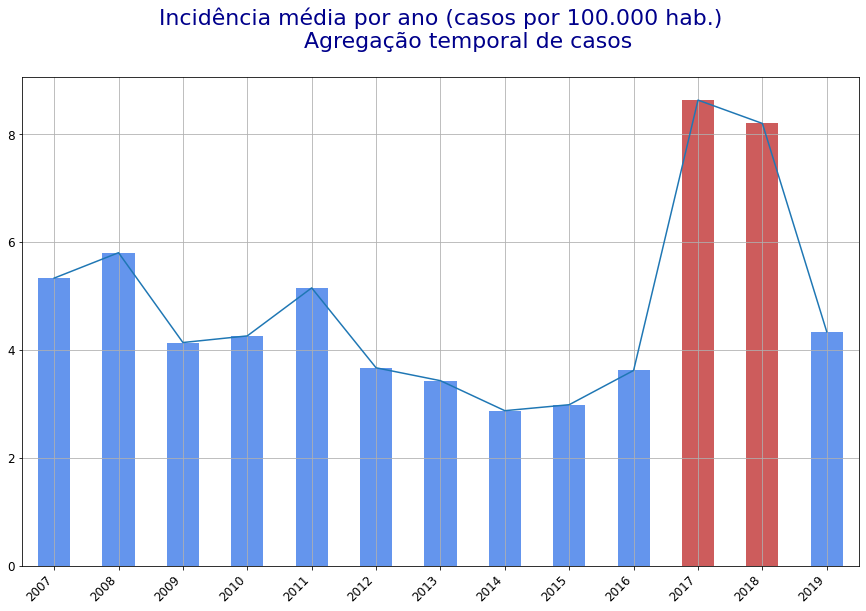

In [5]:
temporal_agregation(para)

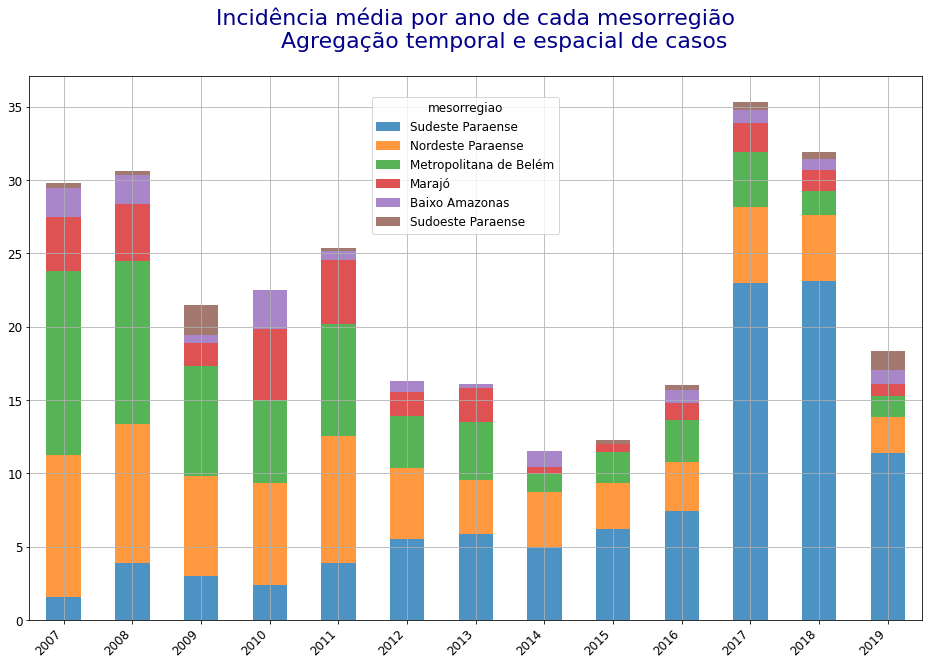

In [6]:
spatial_temporal_agregation(para)